In [1]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import pickle

import torch

import pandas as pd

import networkx as nx

import utils
import evaluation
from net import start_experiments
import graph_statistics
from evaluation import (Evaluation, tabular_from_statistics, df_from_tabular, compute_original_statistics,
                        boxplot, df_from_dataset)

In [2]:
train_graph, xs = utils.load_dict('../data/datasets/eps_nn.p')
train_graph = sp.csr_matrix(train_graph)

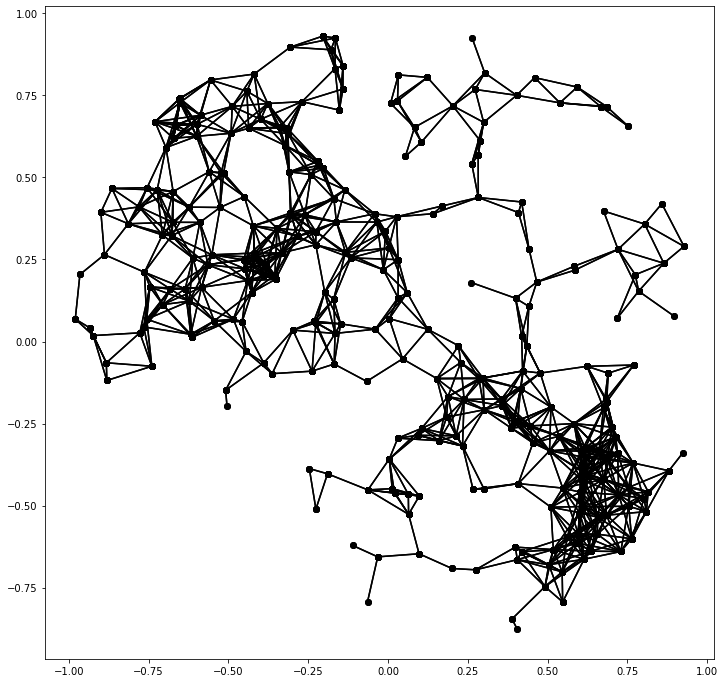

In [3]:
utils.plot_graph(train_graph, xs)

# Train
## Define new loss function that punishes long non-edges

In [18]:
G = nx.from_scipy_sparse_matrix(train_graph)
B = nx.all_pairs_shortest_path_length(G)

B_dict = dict(B)

SP = np.zeros(train_graph.shape)

for start in B_dict.keys():
    for target in B_dict[start].keys():
        SP[start, target] = B_dict[start][target]

In [19]:
def get_my_loss_fn(SP, lam, SP_limit=None):
    SP = torch.tensor(SP)
    if SP_limit:
        SP = lam * (SP <= SP_limit)
    else:
        SP.fill_diagonal_(1)
    def my_loss_fn(W, A, num_edges):
        d = torch.log(torch.exp(W).sum(dim=-1, keepdims=True))
        not_A = 1 - A
        not_A.fill_diagonal_(0)
        
        if SP_limit:
            loss = torch.sum((A + SP) * (d - W))
        else:
            loss = torch.sum((A + lam * (1 / torch.exp(SP))) * (d - W))
        
        
        loss *= .5 / num_edges
        return loss
    return my_loss_fn

## Plain Setting

In [6]:
my_loss_fn = get_my_loss_fn(SP=SP, lam=0, SP_limit=None)
models = start_experiments(num_experiments=5,
                           experiment_root='../logs/eps_nn/Ours_plain',
                           train_graph=train_graph,
                           H=3,
                           optimizer=torch.optim.Adam,
                           optimizer_args={'lr': 0.1,
                                           'weight_decay': 1e-7},
                           invoke_every=5,
                           steps = 100,
                           loss_fn=my_loss_fn,
                           val_edges=(None, None))


Experiment_0
Step:   5/100, Loss: 5.45377, Edge-Overlap: 0.037
Step:  10/100, Loss: 4.81858, Edge-Overlap: 0.090
Step:  15/100, Loss: 4.23537, Edge-Overlap: 0.250
Step:  20/100, Loss: 3.87301, Edge-Overlap: 0.334
Step:  25/100, Loss: 3.60817, Edge-Overlap: 0.336
Step:  30/100, Loss: 3.43356, Edge-Overlap: 0.399
Step:  35/100, Loss: 3.30016, Edge-Overlap: 0.461
Step:  40/100, Loss: 3.19476, Edge-Overlap: 0.475
Step:  45/100, Loss: 3.11161, Edge-Overlap: 0.527
Step:  50/100, Loss: 3.04696, Edge-Overlap: 0.556
Step:  55/100, Loss: 2.99771, Edge-Overlap: 0.569
Step:  60/100, Loss: 2.95270, Edge-Overlap: 0.598
Step:  65/100, Loss: 2.91436, Edge-Overlap: 0.614
Step:  70/100, Loss: 2.88304, Edge-Overlap: 0.629
Step:  75/100, Loss: 2.85898, Edge-Overlap: 0.635
Step:  80/100, Loss: 2.84142, Edge-Overlap: 0.648
Step:  85/100, Loss: 2.82786, Edge-Overlap: 0.658
Step:  90/100, Loss: 2.81647, Edge-Overlap: 0.656
Step:  95/100, Loss: 2.80670, Edge-Overlap: 0.669
Step: 100/100, Loss: 2.79852, Edge-O

## Corrected Setting

In [20]:
my_loss_fn = get_my_loss_fn(SP=SP, lam=1, SP_limit=2)
models = start_experiments(num_experiments=5,
                           experiment_root='../logs/eps_nn/Ours_corrected',
                           train_graph=train_graph,
                           H=20,
                           optimizer=torch.optim.Adam,
                           optimizer_args={'lr': 0.1,
                                           'weight_decay': 1e-7},
                           invoke_every=5,
                           steps = 100,
                           loss_fn=my_loss_fn,
                           val_edges=(None, None))


Experiment_0
Step:   5/100, Loss: 17.21102, Edge-Overlap: 0.187
Step:  10/100, Loss: 13.10716, Edge-Overlap: 0.625
Step:  15/100, Loss: 12.68048, Edge-Overlap: 0.590
Step:  20/100, Loss: 12.27637, Edge-Overlap: 0.468
Step:  25/100, Loss: 12.17298, Edge-Overlap: 0.488
Step:  30/100, Loss: 12.07112, Edge-Overlap: 0.525
Step:  35/100, Loss: 11.99732, Edge-Overlap: 0.520
Step:  40/100, Loss: 11.94750, Edge-Overlap: 0.496
Step:  45/100, Loss: 11.91014, Edge-Overlap: 0.531
Step:  50/100, Loss: 11.88269, Edge-Overlap: 0.523
Step:  55/100, Loss: 11.86259, Edge-Overlap: 0.497
Step:  60/100, Loss: 11.84704, Edge-Overlap: 0.520
Step:  65/100, Loss: 11.83495, Edge-Overlap: 0.536
Step:  70/100, Loss: 11.82617, Edge-Overlap: 0.518
Step:  75/100, Loss: 11.81879, Edge-Overlap: 0.525
Step:  80/100, Loss: 11.81331, Edge-Overlap: 0.524
Step:  85/100, Loss: 11.80814, Edge-Overlap: 0.526
Step:  90/100, Loss: 11.80540, Edge-Overlap: 0.521
Step:  95/100, Loss: 11.80197, Edge-Overlap: 0.527
Step: 100/100, Lo

# Evaluate Graphs

In [21]:
statistic_fns = {'Assortativity':graph_statistics.assortativity,
                 'Average Degree':graph_statistics.average_degree,
                 'Claw Count':graph_statistics.claw_count,
                 'Clustering Coefficient':graph_statistics.clustering_coefficient,
                 'Characteristic Path Length':graph_statistics.compute_cpl,
                 'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                 'Gini':graph_statistics.gini,
                 #'LCC Size':graph_statistics.LCC,
                 'Max Degree':graph_statistics.max_degree,
                 'Min Degree':graph_statistics.min_degree,
                 #'Num Connected Components':graph_statistics.num_connected_components,
                 'Power Law α':graph_statistics.power_law_alpha,
                 'Spectral Gap':graph_statistics.spectral_gap,
                 'Square Count':graph_statistics.square_count,
                 'Triangle Count':graph_statistics.triangle_count,
                 'Wedge Count':graph_statistics.wedge_count,
                 }

In [22]:
target_stats = evaluation.compute_original_statistics(train_graph, statistic_fns)

## Plain Setting

In [23]:
eval_ours = Evaluation(experiment_root='../logs/eps_nn/Ours_plain/',
                       statistic_fns=statistic_fns)

In [8]:
generated_graphs_plain = [eval_ours.load_graph(experiment=i, step=100) for i in range(5)]
statistics_plain = [eval_ours.get_tabular(experiment=i, step=100) for i in range(5)]

In [9]:
generated_graphs_plain, statistics_plain = eval_ours.get_specific_overlap_graph(.5)
generated_graphs_plain = generated_graphs_plain.values()
statistics_plain = statistics_plain.values()
mean_plain = {name: np.mean([elem[name] for elem in statistics_plain]) for name in list(statistics_plain)[0]}

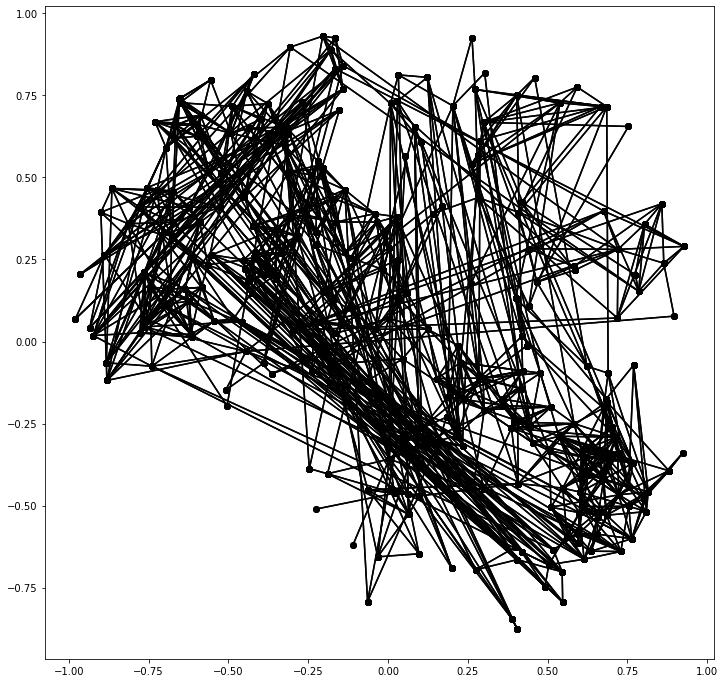

                                  target       sampled
Assortativity                   0.747830      0.344138
Average Degree                  8.446043      8.446043
Claw Count                  42077.000000  34220.000000
Clustering Coefficient          0.165340      0.094506
Characteristic Path Length      8.968236      4.043841
Edge Distribution Entropy       0.974113      0.981636
Gini                            0.299450      0.250150
Max Degree                     22.000000     20.000000
Min Degree                      1.000000      1.000000
Power Law α                     1.510684      1.497313
Spectral Gap                    0.002041      0.039809
Square Count                15091.000000   6144.000000
Triangle Count               2319.000000   1078.000000
Wedge Count                 11557.000000  10700.000000
Edge Overlap (%)                1.000000      0.527257
Time (s)                             NaN      1.630013


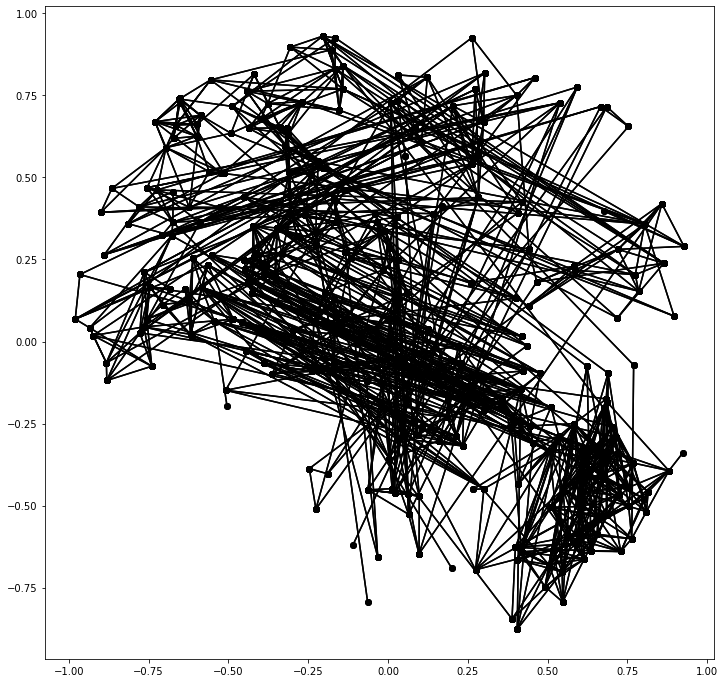

                                  target       sampled
Assortativity                   0.747830      0.419917
Average Degree                  8.446043      8.446043
Claw Count                  42077.000000  39981.000000
Clustering Coefficient          0.165340      0.084940
Characteristic Path Length      8.968236      3.940576
Edge Distribution Entropy       0.974113      0.977687
Gini                            0.299450      0.278035
Max Degree                     22.000000     22.000000
Min Degree                      1.000000      1.000000
Power Law α                     1.510684      1.502864
Spectral Gap                    0.002041      0.040098
Square Count                15091.000000   7169.000000
Triangle Count               2319.000000   1132.000000
Wedge Count                 11557.000000  11243.000000
Edge Overlap (%)                1.000000      0.523850
Time (s)                             NaN      1.552790


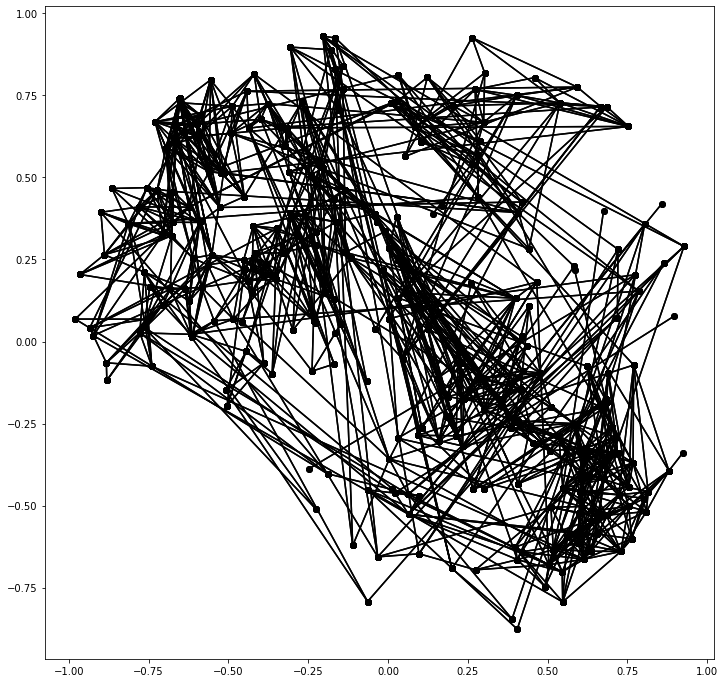

                                  target       sampled
Assortativity                   0.747830      0.327407
Average Degree                  8.446043      8.446043
Claw Count                  42077.000000  38248.000000
Clustering Coefficient          0.165340      0.088632
Characteristic Path Length      8.968236      3.921461
Edge Distribution Entropy       0.974113      0.977365
Gini                            0.299450      0.279895
Max Degree                     22.000000     22.000000
Min Degree                      1.000000      1.000000
Power Law α                     1.510684      1.505056
Spectral Gap                    0.002041      0.035397
Square Count                15091.000000   6940.000000
Triangle Count               2319.000000   1130.000000
Wedge Count                 11557.000000  11169.000000
Edge Overlap (%)                1.000000      0.506814
Time (s)                             NaN      1.367578


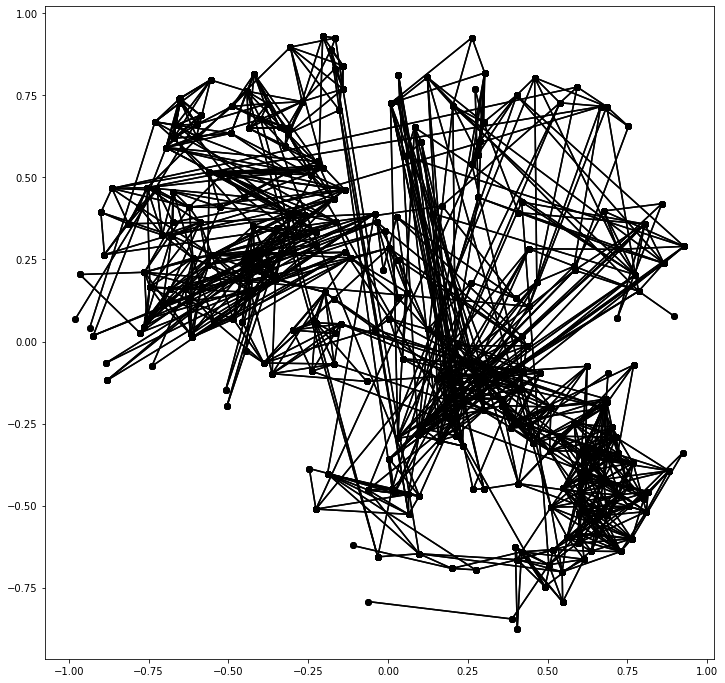

                                  target       sampled
Assortativity                   0.747830      0.358562
Average Degree                  8.446043      8.446043
Claw Count                  42077.000000  39023.000000
Clustering Coefficient          0.165340      0.094175
Characteristic Path Length      8.968236      4.235254
Edge Distribution Entropy       0.974113      0.977252
Gini                            0.299450      0.278605
Max Degree                     22.000000     23.000000
Min Degree                      1.000000      1.000000
Power Law α                     1.510684      1.505074
Spectral Gap                    0.002041      0.021819
Square Count                15091.000000   7449.000000
Triangle Count               2319.000000   1225.000000
Wedge Count                 11557.000000  11205.000000
Edge Overlap (%)                1.000000      0.535775
Time (s)                             NaN      1.697404


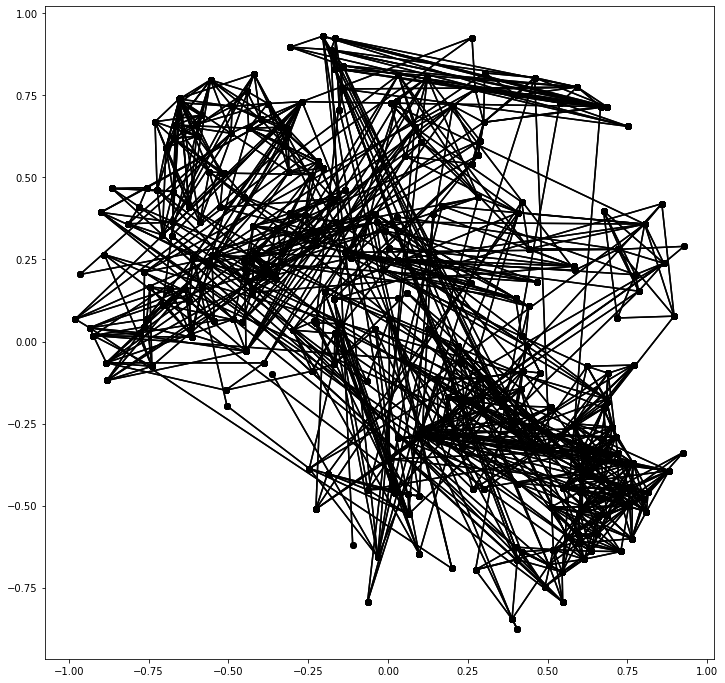

                                  target       sampled
Assortativity                   0.747830      0.468381
Average Degree                  8.446043      8.446043
Claw Count                  42077.000000  36275.000000
Clustering Coefficient          0.165340      0.095686
Characteristic Path Length      8.968236      3.918552
Edge Distribution Entropy       0.974113      0.981401
Gini                            0.299450      0.253907
Max Degree                     22.000000     23.000000
Min Degree                      1.000000      1.000000
Power Law α                     1.510684      1.495906
Spectral Gap                    0.002041      0.041358
Square Count                15091.000000   6856.000000
Triangle Count               2319.000000   1157.000000
Wedge Count                 11557.000000  10831.000000
Edge Overlap (%)                1.000000      0.532368
Time (s)                             NaN      1.710056


In [14]:
for generated_graph, statistic in zip(generated_graphs_plain, statistics_plain):
    utils.plot_graph(generated_graph, xs)
    print(pd.DataFrame({"target": target_stats, "sampled": statistic}))

## Corrected Setting

In [25]:
eval_ours = Evaluation(experiment_root='../logs/eps_nn/Ours_corrected/',
                       statistic_fns=statistic_fns)

In [27]:
generated_graphs_corrected = [eval_ours.load_graph(experiment=i, step=100) for i in range(5)]
statistics_corrected = [eval_ours.get_tabular(experiment=i, step=100) for i in range(5)]

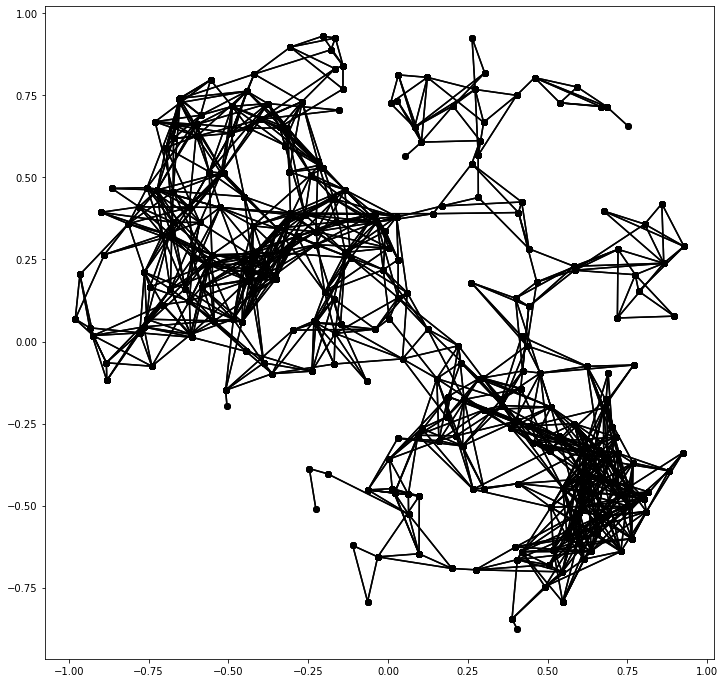

                                  target       sampled
Assortativity                   0.747830      0.487158
Average Degree                  8.446043      8.446043
Claw Count                  42077.000000  38476.000000
Clustering Coefficient          0.165340      0.081869
Characteristic Path Length      8.968236      5.966470
Edge Distribution Entropy       0.974113      0.977829
Gini                            0.299450      0.278268
Max Degree                     22.000000     23.000000
Min Degree                      1.000000      1.000000
Power Law α                     1.510684      1.503135
Spectral Gap                    0.002041      0.005593
Square Count                15091.000000   6586.000000
Triangle Count               2319.000000   1050.000000
Wedge Count                 11557.000000  11160.000000
Edge Overlap (%)                1.000000      0.530664
Time (s)                             NaN      3.410099


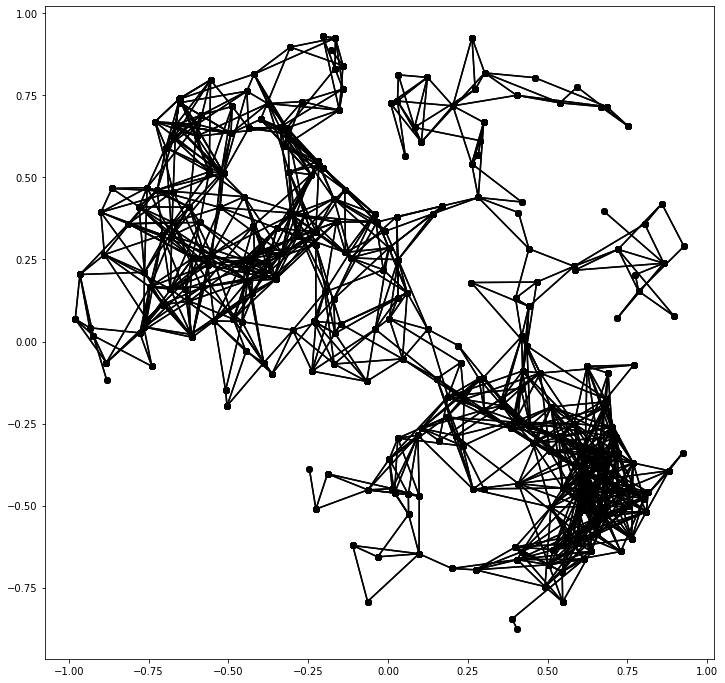

                                  target       sampled
Assortativity                   0.747830      0.547945
Average Degree                  8.446043      8.446043
Claw Count                  42077.000000  43142.000000
Clustering Coefficient          0.165340      0.078856
Characteristic Path Length      8.968236      5.989923
Edge Distribution Entropy       0.974113      0.974720
Gini                            0.299450      0.295096
Max Degree                     22.000000     26.000000
Min Degree                      1.000000      1.000000
Power Law α                     1.510684      1.508283
Spectral Gap                    0.002041      0.004545
Square Count                15091.000000   7833.000000
Triangle Count               2319.000000   1134.000000
Wedge Count                 11557.000000  11569.000000
Edge Overlap (%)                1.000000      0.519591
Time (s)                             NaN      3.297550


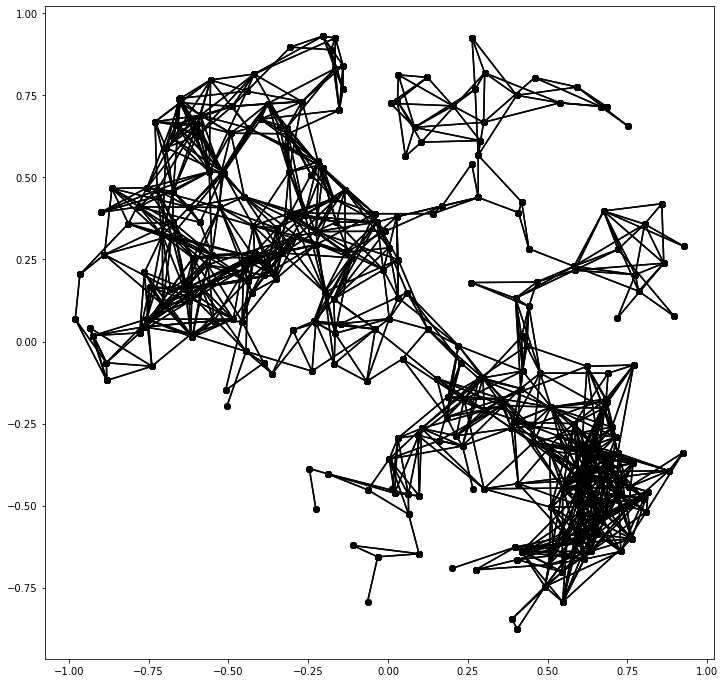

                                  target       sampled
Assortativity                   0.747830      0.412566
Average Degree                  8.446043      8.446043
Claw Count                  42077.000000  39791.000000
Clustering Coefficient          0.165340      0.081727
Characteristic Path Length      8.968236      5.860323
Edge Distribution Entropy       0.974113      0.976556
Gini                            0.299450      0.285343
Max Degree                     22.000000     23.000000
Min Degree                      1.000000      1.000000
Power Law α                     1.510684      1.505656
Spectral Gap                    0.002041      0.004972
Square Count                15091.000000   6728.000000
Triangle Count               2319.000000   1084.000000
Wedge Count                 11557.000000  11298.000000
Edge Overlap (%)                1.000000      0.516184
Time (s)                             NaN      3.323250


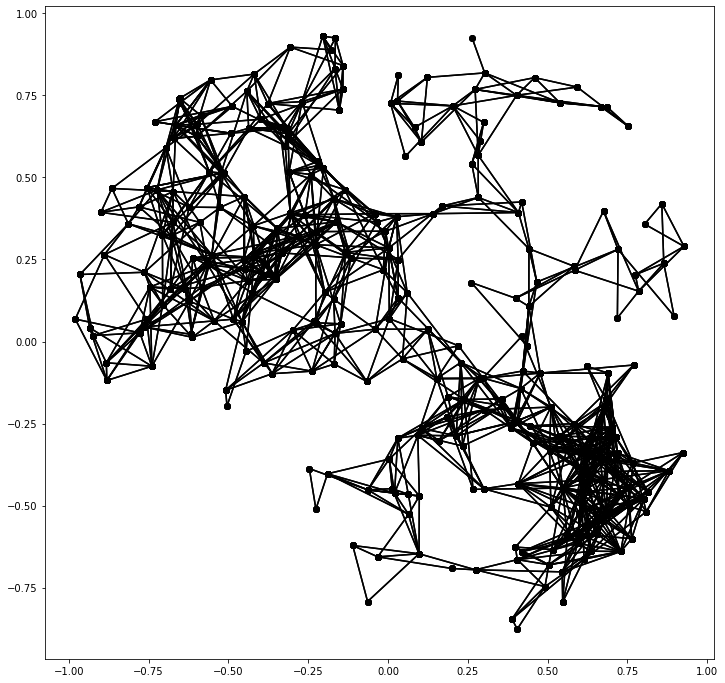

                                  target       sampled
Assortativity                   0.747830      0.484726
Average Degree                  8.446043      8.446043
Claw Count                  42077.000000  40756.000000
Clustering Coefficient          0.165340      0.079866
Characteristic Path Length      8.968236      5.776251
Edge Distribution Entropy       0.974113      0.977423
Gini                            0.299450      0.280563
Max Degree                     22.000000     27.000000
Min Degree                      1.000000      1.000000
Power Law α                     1.510684      1.502285
Spectral Gap                    0.002041      0.006072
Square Count                15091.000000   7155.000000
Triangle Count               2319.000000   1085.000000
Wedge Count                 11557.000000  11296.000000
Edge Overlap (%)                1.000000      0.524702
Time (s)                             NaN      3.337650


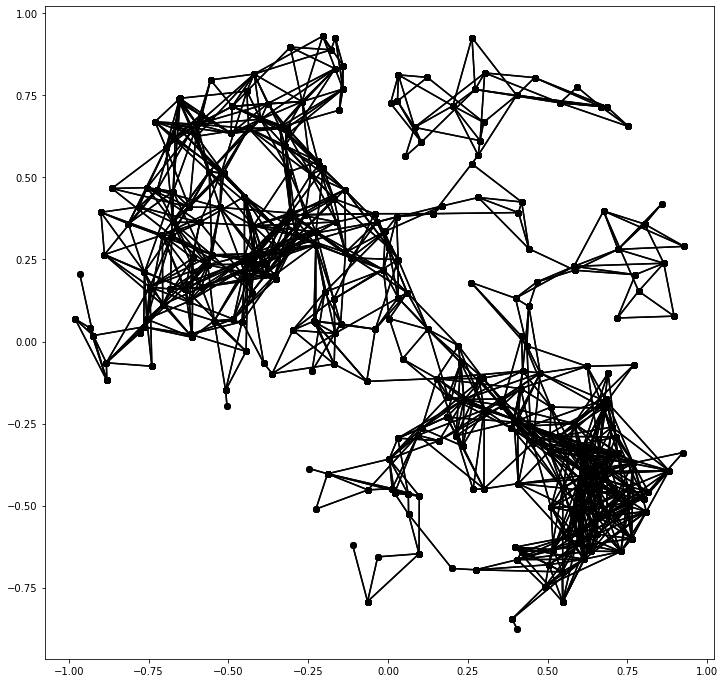

                                  target       sampled
Assortativity                   0.747830      0.436470
Average Degree                  8.446043      8.446043
Claw Count                  42077.000000  42310.000000
Clustering Coefficient          0.165340      0.077074
Characteristic Path Length      8.968236      5.995299
Edge Distribution Entropy       0.974113      0.974621
Gini                            0.299450      0.299643
Max Degree                     22.000000     23.000000
Min Degree                      1.000000      1.000000
Power Law α                     1.510684      1.507847
Spectral Gap                    0.002041      0.004441
Square Count                15091.000000   7015.000000
Triangle Count               2319.000000   1087.000000
Wedge Count                 11557.000000  11560.000000
Edge Overlap (%)                1.000000      0.518739
Time (s)                             NaN      3.315148


In [28]:
for generated_graph, statistic in zip(generated_graphs_corrected, statistics_corrected):
    utils.plot_graph(generated_graph, xs)
    print(pd.DataFrame({"target": target_stats, "sampled": statistic}))

In [38]:
mean_corrected, std_corrected = eval_ours.get_seleted_average(experiments=[0,1,2,3,4], steps=5*[19])

## NetGan

In [44]:
eval_netgan = Evaluation(experiment_root='../logs/eps_nn/NetGan/',
                         statistic_fns=statistic_fns)

In [60]:
generated_graphs_netgan, statistics_netgan = eval_netgan.get_specific_overlap_graph(.5)
generated_graphs_netgan = generated_graphs_netgan.values()
statistics_netgan = statistics_netgan.values()
mean_netgan = {name: np.mean([elem[name] for elem in statistics_netgan]) for name in list(statistics_netgan)[0]}

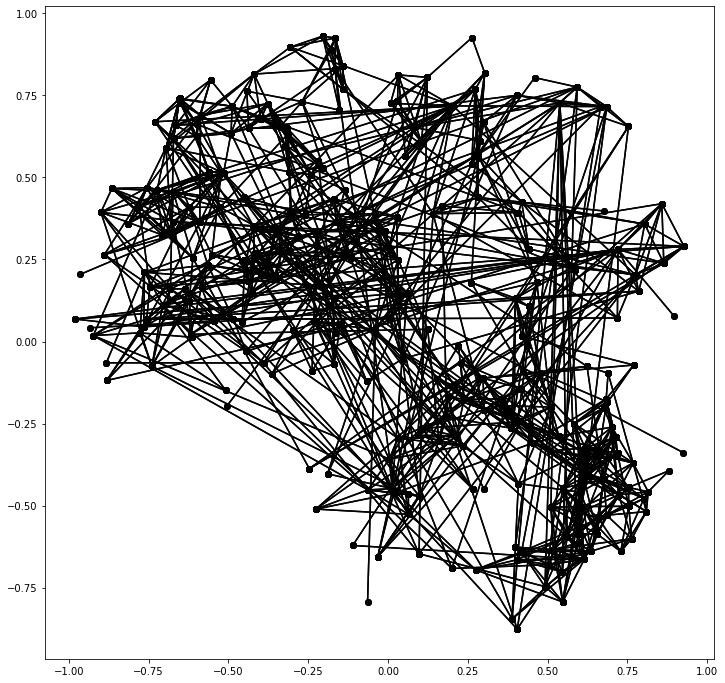

                                  target       sampled
Assortativity                   0.747830      0.073614
Average Degree                  8.446043      8.446043
Claw Count                  42077.000000  32469.000000
Clustering Coefficient          0.165340      0.085097
Characteristic Path Length      8.968236      3.516947
Edge Distribution Entropy       0.974113      0.983052
Gini                            0.299450      0.236139
Max Degree                     22.000000     22.000000
Min Degree                      1.000000      1.000000
Power Law α                     1.510684      1.496431
Spectral Gap                    0.002041      0.052145
Square Count                15091.000000   4358.000000
Triangle Count               2319.000000    921.000000
Wedge Count                 11557.000000  10506.000000
Edge Overlap (%)                1.000000      0.523850
ROC-AUC Score                        NaN      1.000000
Average Precision                    NaN      1.000000
Time (s)  

In [61]:
for generated_graph, statistic in zip(generated_graphs_netgan, statistics_netgan):
    utils.plot_graph(generated_graph, xs)
    print(pd.DataFrame({"target": target_stats, "sampled": statistic}))

In [48]:
graph_netgan, statistics_netgan = eval_netgan.get_specific_overlap_graph(.5)

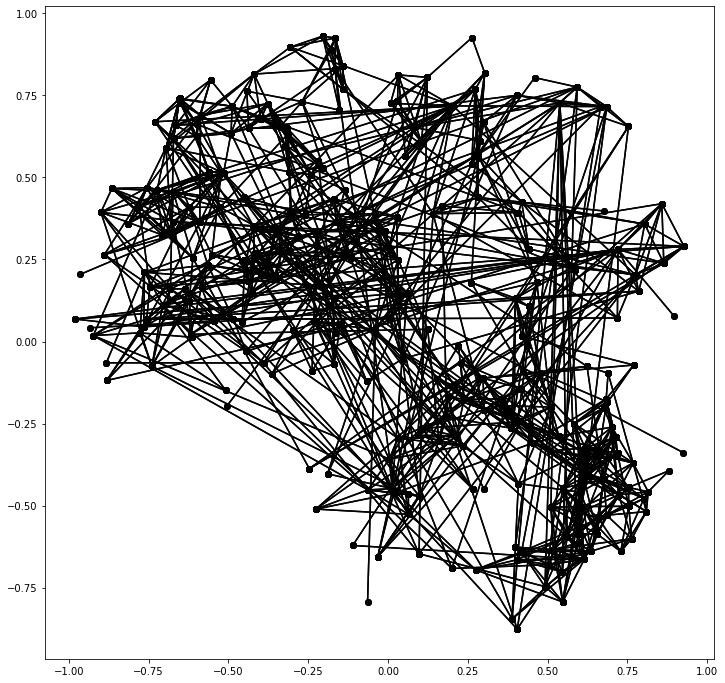

In [51]:
utils.plot_graph(graph_netgan[0], xs)

## Comparison

In [52]:
stats[0]

{'Assortativity': 0.07361387819141815,
 'Average Degree': 8.446043165467627,
 'Claw Count': 32469.0,
 'Clustering Coefficient': 0.08509655363577566,
 'Characteristic Path Length': 3.5169467314235257,
 'Edge Distribution Entropy': 0.9830520808798474,
 'Gini': 0.23613851678452802,
 'Max Degree': 22.0,
 'Min Degree': 1.0,
 'Power Law α': 1.496431397273415,
 'Spectral Gap': 0.052144712569874366,
 'Square Count': 4358.0,
 'Triangle Count': 921.0,
 'Wedge Count': 10506.0,
 'Edge Overlap (%)': 0.5238500851788757,
 'ROC-AUC Score': 1.0,
 'Average Precision': 1.0,
 'Time (s)': 342.76168513298035}

In [59]:
print(pd.DataFrame({"target": target_stats,
                    "sampled_corrected": mean_corrected,
                    "sampled_plain": mean_plain,
                    "sampled_netgan": statistics_netgan[0]}))

                                  target  sampled_corrected  sampled_plain  \
Assortativity                   0.747830           0.473773       0.383681   
Average Degree                  8.446043           8.446043       8.446043   
Claw Count                  42077.000000       40895.000000   37549.400000   
Clustering Coefficient          0.165340           0.079878       0.091588   
Characteristic Path Length      8.968236           5.917653       4.011937   
Edge Distribution Entropy       0.974113           0.976230       0.979068   
Gini                            0.299450           0.287783       0.268119   
Max Degree                     22.000000          24.400000      22.000000   
Min Degree                      1.000000           1.000000       1.000000   
Power Law α                     1.510684           1.505441       1.501243   
Spectral Gap                    0.002041           0.005125       0.035696   
Square Count                15091.000000        7063.400000    6

In [22]:
for statistic_corrected, statistic_plain in zip(statistics_corrected, statistics_plain):
    print('\n',pd.DataFrame({"target": target_stats,
                             "sampled_corrected": statistic_corrected,
                             "sampled_plain": statistic_plain}))


                                   target  sampled_corrected  sampled_plain
Assortativity                   0.747830           0.427375       0.365003
Average Degree                  8.446043           8.446043       8.446043
Claw Count                  42077.000000       36927.000000   36405.000000
Clustering Coefficient          0.165340           0.082216       0.094850
Characteristic Path Length      8.968236           5.903722       3.950939
Edge Distribution Entropy       0.974113           0.977317       0.979633
Gini                            0.299450           0.278936       0.265890
Max Degree                     22.000000          19.000000      22.000000
Min Degree                      1.000000           1.000000       1.000000
Power Law α                     1.510684           1.506121       1.500330
Spectral Gap                    0.002041           0.004244       0.031747
Square Count                15091.000000        6081.000000    6956.000000
Triangle Count         

# Make final table and plots

#### Functions with additional parameters (currying)

In [3]:
inv_train_graph = sp.csr_matrix(1 - train_graph.toarray())

In [4]:
inv_train_graph.multiply(train_graph)

<278x278 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [5]:
def get_average_edgelength(Xs, train_graph):
    inv_train_graph = 1 - train_graph.toarray()
    inv_train_graph = sp.csr_matrix(inv_train_graph)
    def average_edgelength(A):
        return graph_statistics.average_edgelength(A_in=A.multiply(inv_train_graph), Xs=Xs)
    return average_edgelength

def get_average_SP_in_original_graph(train_graph):
    G = nx.from_scipy_sparse_matrix(train_graph)
    B_dict = dict(nx.all_pairs_shortest_path_length(G))
    SP = np.zeros(train_graph.shape)
    for start in B_dict.keys():
        for target in B_dict[start].keys():
            SP[start, target] = B_dict[start][target]
        def average_SP_in_original_graph(A):
            return graph_statistics.average_SP_in_original_graph(A_in=A, SP=SP)
    return average_SP_in_original_graph

In [6]:
statistic_fns = {'Assortativity':graph_statistics.assortativity,
                 'Avg. Edge Length':get_average_edgelength(Xs=xs, train_graph=train_graph),
                 'Avg. SP in Original Graph':get_average_SP_in_original_graph(train_graph),
                 'Average Degree':graph_statistics.average_degree,
#                  'Claw Count':graph_statistics.claw_count,
                 'Clustering Coefficient':graph_statistics.clustering_coefficient,
                 'Characteristic Path Length':graph_statistics.compute_cpl,
                 #'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                 #'Gini':graph_statistics.gini,
                 #'LCC Size':graph_statistics.LCC,
                 'Max Degree':graph_statistics.max_degree,
                 #'Min Degree':graph_statistics.min_degree,
                 #'Num Connected Components':graph_statistics.num_connected_components,
                 'Power Law α':graph_statistics.power_law_alpha,
                 'Spectral Gap':graph_statistics.spectral_gap,
                 'Square Count':graph_statistics.square_count,
                 'Triangle Count':graph_statistics.triangle_count,
                 'Wedge Count':graph_statistics.wedge_count,
                 }

__Note__: I needed to switch step 005 with step 100 (also corresponding entries in timings and overlaps) for our corrected setting, because the function df_from_dataset always takes the first instance with sufficient edge overlap. But we want the last here.

In [7]:
# for i in range(5):
#     d = utils.load_dict(f'../logs/eps_nn/Ours_corrected/Experiment_{i}/sampled_graphs/timing.pickle')
#     d[5], d[100] = d[100], d[5]
#     utils.save_dict(d, f'../logs/eps_nn/Ours_corrected/Experiment_{i}/sampled_graphs/timing.pickle')

In [8]:
df, evals = df_from_dataset(path_to_dataset='../logs/eps_nn/', statistic_fns=statistic_fns,
                            target_overlap=0.5,
                            original_graph=train_graph)

In [9]:
df

,Assortativity,Avg. Edge Length,Avg. SP in Original Graph,Average Degree,Clustering Coefficient,Characteristic Path Length,Max Degree,Power Law α,Spectral Gap,Square Count,Triangle Count,Wedge Count,Edge Overlap (%),ROC-AUC Score,Average Precision,Time (s)
eps_nn,0.747830,*,1.000000,8.446043,0.165340,8.968236,22.0,1.510684,0.002041,15091.0,2319.0,11557.0,1.000000,NaN,NaN,NaN
NetGan,0.093702,0.407471,2.633731,8.446043,0.079574,3.537428,21.4,1.498169,0.044878,4260.6,895.0,10638.2,0.514991,1.0,1.0,418.005780
Ours_corrected,0.473773,0.211506,1.487905,8.446043,0.079878,5.917653,24.4,1.505441,0.005125,7063.4,1088.0,11376.6,0.521976,NaN,NaN,3.336739
Ours_plain,0.383681,0.494341,3.043271,8.446043,0.091588,4.011937,22.0,1.501243,0.035696,6911.6,1144.4,11029.6,0.525213,NaN,NaN,1.591568


In [10]:
df.keys()

Index(['Assortativity', 'Avg. Edge Length', 'Avg. SP in Original Graph',
       'Average Degree', 'Clustering Coefficient',
       'Characteristic Path Length', 'Max Degree', 'Power Law α',
       'Spectral Gap', 'Square Count', 'Triangle Count', 'Wedge Count',
       'Edge Overlap (%)', 'ROC-AUC Score', 'Average Precision', 'Time (s)'],
      dtype='object')

In [11]:
df_for_paper = df.drop(['Edge Overlap (%)', 'ROC-AUC Score', 'Average Precision', 'Time (s)'], axis=1)

In [12]:
df_for_paper.keys()

Index(['Assortativity', 'Avg. Edge Length', 'Avg. SP in Original Graph',
       'Average Degree', 'Clustering Coefficient',
       'Characteristic Path Length', 'Max Degree', 'Power Law α',
       'Spectral Gap', 'Square Count', 'Triangle Count', 'Wedge Count'],
      dtype='object')

In [13]:
df_for_paper = df_for_paper.reindex(['eps_nn', 'NetGan', 'Ours_plain', 'Ours_corrected'])

In [14]:
df_for_paper[['Characteristic Path Length', 'Avg. SP in Original Graph', 'Avg. Edge Length',
              'Spectral Gap', 
              'Assortativity',
              'Power Law α',
              'Triangle Count', 
              'Wedge Count']]

,Characteristic Path Length,Avg. SP in Original Graph,Avg. Edge Length,Spectral Gap,Assortativity,Power Law α,Triangle Count,Wedge Count
eps_nn,8.968236,1.000000,*,0.002041,0.747830,1.510684,2319.0,11557.0
NetGan,3.537428,2.633731,0.407471,0.044878,0.093702,1.498169,895.0,10638.2
Ours_plain,4.011937,3.043271,0.494341,0.035696,0.383681,1.501243,1144.4,11029.6
Ours_corrected,5.917653,1.487905,0.211506,0.005125,0.473773,1.505441,1088.0,11376.6


# Make figure

Load other graphs

In [133]:
print(utils.load_dict('../logs/eps_nn/NetGan/Experiment_0/sampled_graphs/overlap.pickle'))

{1: 0.051959114139693355, 2: 0.10562180579216354, 3: 0.1643952299829642, 4: 0.21805792163543442, 5: 0.303236797274276, 6: 0.35093696763202725, 7: 0.42674616695059625, 8: 0.5153321976149915, 9: 0.5638841567291312, 10: 0.5996592844974447, 11: 0.6328790459965928, 12: 0.6320272572402045, 13: 0.6601362862010222, 14: 0.6856899488926746, 15: 0.6908006814310051, 16: 0.7240204429301533, 17: 0.7282793867120954, 18: 0.768313458262351, 19: 0.7734241908006815}


In [136]:
print(utils.load_dict('../logs/eps_nn/Ours_plain/Experiment_0/sampled_graphs/overlap.pickle'))

{5: 0.03747870528109029, 10: 0.09028960817717206, 15: 0.2495741056218058, 20: 0.3339011925042589, 25: 0.33560477001703576, 30: 0.39948892674616693, 35: 0.4608177172061329, 40: 0.4752981260647359, 45: 0.5272572402044293, 50: 0.5562180579216355, 55: 0.5689948892674617, 60: 0.5979557069846678, 65: 0.6141396933560477, 70: 0.6286201022146508, 75: 0.6354344122657581, 80: 0.6482112436115843, 85: 0.6584327086882453, 90: 0.65587734241908, 95: 0.6686541737649063, 100: 0.6626916524701874}


In [137]:
print(utils.load_dict('../logs/eps_nn/Ours_corrected/Experiment_0/sampled_graphs/overlap.pickle'))

{5: 0.530664395229983, 10: 0.6252129471890971, 15: 0.590289608177172, 20: 0.4676320272572402, 25: 0.48807495741056217, 30: 0.524701873935264, 35: 0.5195911413969335, 40: 0.4957410562180579, 45: 0.530664395229983, 50: 0.5229982964224872, 55: 0.49744463373083475, 60: 0.5195911413969335, 65: 0.5357751277683135, 70: 0.5178875638841567, 75: 0.524701873935264, 80: 0.5238500851788757, 85: 0.5264054514480409, 90: 0.5212947189097104, 95: 0.5272572402044293, 100: 0.18739352640545145}


In [138]:
NetGAN_graph = load_npz('../logs/eps_nn/NetGan/Experiment_0/sampled_graphs/graph_08.npz')
LRL_graph = load_npz('../logs/eps_nn/Ours_plain/Experiment_0/sampled_graphs/graph_045.npz')
Local_LRL_graph = load_npz('../logs/eps_nn/Ours_corrected/Experiment_0/sampled_graphs/graph_005.npz')

In [146]:
rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False}
plt.rcParams.update({'font.size': 22})

def plot_many(graphs, Xs, titles, save=False):
    f, axs = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True)
    axs=axs.flatten()
    for i in range(len(graphs)):
        Is, Js = graphs[i].nonzero()
        nonzero_indices = np.array((Is, Js)).T
        for l in range(nonzero_indices.shape[0]):
            style = 'ko-'
            axs[i].plot(Xs[nonzero_indices[l], 0], Xs[nonzero_indices[l], 1], style)
            axs[i].set_title(titles[i])
    if save:
        plt.savefig('../fig/eps_nn_graphs.pdf')
    return

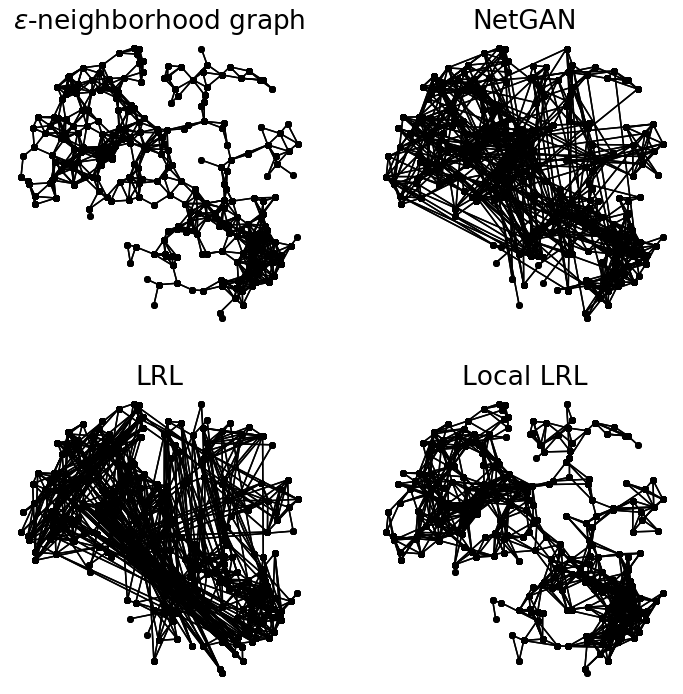

In [147]:
plot_many([train_graph, NetGAN_graph, LRL_graph, Local_LRL_graph], xs, 
          titles=[r'$\varepsilon$-neighborhood graph', 'NetGAN', 'LRL', 'Local LRL'],
          save=True)